# BERT Cased with Interweaving Fine-Tuned Approach on Disability and Sexual Orientation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.6 MB/s eta 0:00:00


In [3]:
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 12.1 MB/s eta 0:00:00


In [4]:
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from transformers import AutoTokenizer,TFBertModel

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Functions and Constants

In [7]:
def to_arrays(df):
  X = df['comment_text'].to_numpy()
  y = df['toxicity_binary'].to_numpy()
  return X, y

In [8]:
MAX_SEQUENCE_LENGTH = 128

In [9]:
def tokenizing_pipeline(X, tokenizer):
  bert_tokenized = tokenizer(list(X),
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  bert_inputs = [bert_tokenized.input_ids,
                 bert_tokenized.token_type_ids,
                 bert_tokenized.attention_mask]
  return bert_inputs

def load_data(group):
  df_train = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-train-augmented.csv')
  df_val = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-val-augmented.csv')
  df_test = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-test-augmented.csv')

  return df_train, df_val, df_test

def load_data_as_arr(df_train, df_val, df_test):

  X_train, y_train = to_arrays(df_train)
  X_val, y_val = to_arrays(df_val)
  X_test, y_test = to_arrays(df_test)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [10]:
def build_bertcased_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size=100, 
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0):

    # freeze all pre-trained BERT Cased layers
    if num_train_layers == 0:
      bertcased_model.trainable = False

    # partially freeze the first n pre-trained BERT Cased layers
    else:
        for layer_num in range(num_train_layers):
            bertcased_model.bert.encoder.layer[layer_num].trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    # Use the same bertcased model instance
    bert_out = bertcased_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])

    return classification_model

## Load All Available Data for Disability and Nationality

In [12]:
# Disability
disability_train_df, disability_val_df, disability_test_df = load_data('disability')
X_disability_train, y_disability_train, X_disability_test, y_disability_test, X_disability_val, y_disability_val = load_data_as_arr(disability_train_df, disability_val_df, disability_test_df)

# Sexual Orientation
sexual_orientation_train_df, sexual_orientation_val_df, sexual_orientation_test_df = load_data('sexual-orientation')
X_sexual_orientation_train, y_sexual_orientation_train, X_sexual_orientation_test, y_sexual_orientation_test, X_sexual_orientation_val, y_sexual_orientation_val = load_data_as_arr(sexual_orientation_train_df, sexual_orientation_val_df, sexual_orientation_test_df)

In [13]:
X_disability_train[1]

' mental disability is extremely physical'

In [14]:
X_disability_train[9]

' There are many different types of disabilities. For example: mental, cognitive, visual, hearing, physical, and speech. Some people physically cannot speak English'

In [15]:
len(X_disability_train)

24904

In [16]:
X_sexual_orientation_train[0]

' have you had a boyfriend before?'

In [17]:
len(X_sexual_orientation_train)

15344

## Load BERT Cased Model from_pretrained()

In [18]:
bertcased_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bertcased_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
bertcased_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


## Tokenize Data Splits

In [20]:
# Disability
bertcased_disability_train_inputs = tokenizing_pipeline(X_disability_train, bertcased_tokenizer)
bertcased_disability_test_inputs = tokenizing_pipeline(X_disability_test, bertcased_tokenizer)
bertcased_disability_val_inputs = tokenizing_pipeline(X_disability_val, bertcased_tokenizer)

# Sexual Orientation
bertcased_sexual_orientation_train_inputs = tokenizing_pipeline(X_sexual_orientation_train, bertcased_tokenizer)
bertcased_sexual_orientation_test_inputs = tokenizing_pipeline(X_sexual_orientation_test, bertcased_tokenizer)
bertcased_sexual_orientation_val_inputs = tokenizing_pipeline(X_sexual_orientation_val, bertcased_tokenizer)

# Calculate Class Weights for Each Group

Get class weights for disability train set:

In [21]:
neg, pos = np.bincount(y_disability_train)
total = neg + pos
print('Disability Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

disability_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Disability Weight for class 0: {:.2f}'.format(weight_for_0))
print('Disability Weight for class 1: {:.2f}'.format(weight_for_1))

Disability Examples:
    Total: 24904
    Positive: 13009 (52.24% of total)

Disability Weight for class 0: 1.05
Disability Weight for class 1: 0.96


Get class weights for sexual orientation train set:

In [22]:
neg, pos = np.bincount(y_sexual_orientation_train)
total = neg + pos
print('Sexual Orientation Train Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

sexual_orientation_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Sexual Orientation Train Weight for class 0: {:.2f}'.format(weight_for_0))
print('Sexual Orientation Train Weight for class 1: {:.2f}'.format(weight_for_1))

Sexual Orientation Train Examples:
    Total: 15344
    Positive: 7415 (48.33% of total)

Sexual Orientation Train Weight for class 0: 0.97
Sexual Orientation Train Weight for class 1: 1.03


### Define Hyperparameters for both models

In [23]:
# hyperparameters
batch_size=24
num_train_layers=8
learning_rate=1e-6

# Build Disability Model

In [24]:
disability_model = build_bertcased_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
disability_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

# Build Sexual Orientation Model

In [25]:
sexual_orientation_model = build_bertcased_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
sexual_orientation_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

# Interweaving Fine-Tuning: Train Disability and Sexual Orientation Models on ther Respective Data

## Round 1: Train Disability Model for 1 epochs

In [26]:
disability_round1_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 96s 76ms/step - loss: 0.5958 - binary_accuracy: 0.6760 - precision: 0.6922 - recall: 0.6838 - f1_score: 0.6880 - val_loss: 0.4935 - val_binary_accuracy: 0.7630 - val_precision: 0.7785 - val_recall: 0.7589 - val_f1_score: 0.7686


## Round 2: Train Nationality Model for 1 epoch

In [27]:
sexual_orientation_round2_history = sexual_orientation_model.fit(bertcased_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertcased_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 68s 82ms/step - loss: 0.5970 - binary_accuracy: 0.6781 - precision_1: 0.6582 - recall_1: 0.6945 - f1_score: 0.6759 - val_loss: 0.4719 - val_binary_accuracy: 0.7784 - val_precision_1: 0.7596 - val_recall_1: 0.8048 - val_f1_score: 0.7815


## Round 3: Train Disability Model for 1 epoch

In [28]:
disability_round3_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.4849 - binary_accuracy: 0.7701 - precision: 0.7864 - recall: 0.7687 - f1_score: 0.7775 - val_loss: 0.4653 - val_binary_accuracy: 0.7811 - val_precision: 0.8161 - val_recall: 0.7459 - val_f1_score: 0.7794


## Round 4: Train Nationality Model on for 1 epoch

In [29]:
sexual_orientation_round4_history = sexual_orientation_model.fit(bertcased_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertcased_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 49s 77ms/step - loss: 0.4522 - binary_accuracy: 0.7884 - precision_1: 0.7746 - recall_1: 0.7927 - f1_score: 0.7836 - val_loss: 0.3906 - val_binary_accuracy: 0.8249 - val_precision_1: 0.8279 - val_recall_1: 0.8135 - val_f1_score: 0.8207


## Round 5: Train Disability Model for 1 epoch

In [30]:
disability_round5_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.4570 - binary_accuracy: 0.7852 - precision: 0.7994 - recall: 0.7860 - f1_score: 0.7926 - val_loss: 0.4473 - val_binary_accuracy: 0.7926 - val_precision: 0.8007 - val_recall: 0.7989 - val_f1_score: 0.7998


## Round 6: Train Nationality Model for 1 epoch

In [31]:
sexual_orientation_round6_history = sexual_orientation_model.fit(bertcased_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertcased_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 49s 77ms/step - loss: 0.3955 - binary_accuracy: 0.8215 - precision_1: 0.8135 - recall_1: 0.8182 - f1_score: 0.8158 - val_loss: 0.3629 - val_binary_accuracy: 0.8425 - val_precision_1: 0.8356 - val_recall_1: 0.8468 - val_f1_score: 0.8412



## Round 7: Train Disability Model for 1 epoch

In [32]:
disability_round7_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.4415 - binary_accuracy: 0.7926 - precision: 0.8110 - recall: 0.7863 - f1_score: 0.7985 - val_loss: 0.4376 - val_binary_accuracy: 0.7972 - val_precision: 0.8147 - val_recall: 0.7882 - val_f1_score: 0.8012


## Round 8: Train Nationality Model for 1 epoch

In [33]:
sexual_orientation_round8_history = sexual_orientation_model.fit(bertcased_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertcased_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 49s 77ms/step - loss: 0.3619 - binary_accuracy: 0.8383 - precision_1: 0.8316 - recall_1: 0.8344 - f1_score: 0.8330 - val_loss: 0.3492 - val_binary_accuracy: 0.8453 - val_precision_1: 0.8547 - val_recall_1: 0.8262 - val_f1_score: 0.8402


## Round 9: Train Disability Model for 1 epoch

In [34]:
disability_round9_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 74ms/step - loss: 0.4280 - binary_accuracy: 0.8021 - precision: 0.8232 - recall: 0.7911 - f1_score: 0.8068 - val_loss: 0.4335 - val_binary_accuracy: 0.7970 - val_precision: 0.8027 - val_recall: 0.8068 - val_f1_score: 0.8047


## Round 10: Train Nationality Model for 1 epoch

In [35]:
sexual_orientation_round10_history = sexual_orientation_model.fit(bertcased_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertcased_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 49s 77ms/step - loss: 0.3478 - binary_accuracy: 0.8485 - precision_1: 0.8417 - recall_1: 0.8454 - f1_score: 0.8436 - val_loss: 0.3425 - val_binary_accuracy: 0.8492 - val_precision_1: 0.8266 - val_recall_1: 0.8778 - val_f1_score: 0.8514


## Checkpoint #1: Save Model Weights for Rounds 9 and 10

In [36]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Sexual_Orientation_Interwoven_disability-checkpt1-rounds_9_10.hdf5')
sexual_orientation_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Sexual_Orientation_Interwoven_sexual_orientation-checkpt1-rounds_9_10.hdf5')

## Round 11: Train Disability Model for 1 epoch

In [37]:
disability_round11_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 75ms/step - loss: 0.4171 - binary_accuracy: 0.8076 - precision: 0.8276 - recall: 0.7978 - f1_score: 0.8124 - val_loss: 0.4261 - val_binary_accuracy: 0.8030 - val_precision: 0.8141 - val_recall: 0.8035 - val_f1_score: 0.8088


## Round 12: Train Nationality Model for 1 epoch

In [38]:
sexual_orientation_round12_history = sexual_orientation_model.fit(bertcased_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertcased_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 49s 77ms/step - loss: 0.3301 - binary_accuracy: 0.8578 - precision_1: 0.8518 - recall_1: 0.8543 - f1_score: 0.8531 - val_loss: 0.3298 - val_binary_accuracy: 0.8499 - val_precision_1: 0.8532 - val_recall_1: 0.8397 - val_f1_score: 0.8464


## Checkpoint #2: Save Model Weights for Rounds 11 and 12

In [39]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Sexual_Orientation_Interwoven_disability-checkpt2-rounds_11_12.hdf5')
sexual_orientation_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Sexual_Orientation_Interwoven_sexual_orientation-checkpt2-rounds_11_12.hdf5')

## Round 13: Train Disability Model for 1 epoch

In [40]:
disability_round13_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.4056 - binary_accuracy: 0.8140 - precision: 0.8333 - recall: 0.8049 - f1_score: 0.8189 - val_loss: 0.4213 - val_binary_accuracy: 0.8095 - val_precision: 0.8332 - val_recall: 0.7910 - val_f1_score: 0.8115


## Round 14: Train Nationality Model on for 1 epoch

In [41]:
sexual_orientation_round14_history = sexual_orientation_model.fit(bertcased_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertcased_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 49s 77ms/step - loss: 0.3203 - binary_accuracy: 0.8613 - precision_1: 0.8570 - recall_1: 0.8558 - f1_score: 0.8564 - val_loss: 0.3243 - val_binary_accuracy: 0.8538 - val_precision_1: 0.8590 - val_recall_1: 0.8413 - val_f1_score: 0.8500


## Checkpoint #3: Save Model Weights for Rounds 13 and 14

In [42]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Sexual_Orientation_Interwoven_disability-checkpt3-rounds_13_14.hdf5')
sexual_orientation_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Sexual_Orientation_Interwoven_sexual_orientation-checkpt3-rounds_13_14.hdf5')

## Round 15: Train Disability Model for 1 epoch

In [43]:
disability_round15_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 78s 75ms/step - loss: 0.3977 - binary_accuracy: 0.8192 - precision: 0.8383 - recall: 0.8102 - f1_score: 0.8240 - val_loss: 0.4167 - val_binary_accuracy: 0.8133 - val_precision: 0.8297 - val_recall: 0.8054 - val_f1_score: 0.8173


## Round 16: Train Nationality Model on for 1 epoch

In [44]:
sexual_orientation_round16_history = sexual_orientation_model.fit(bertcased_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertcased_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 49s 77ms/step - loss: 0.3085 - binary_accuracy: 0.8690 - precision_1: 0.8645 - recall_1: 0.8645 - f1_score: 0.8645 - val_loss: 0.3221 - val_binary_accuracy: 0.8574 - val_precision_1: 0.8618 - val_recall_1: 0.8460 - val_f1_score: 0.8538


## Checkpoint #4: Save Model Weights for Rounds 15 and 16

In [45]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Sexual_Orientation_Interwoven_disability-checkpt4-rounds_15_16.hdf5')
sexual_orientation_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Sexual_Orientation_Interwoven_sexual_orientation-checkpt4-rounds_15_16.hdf5')

## Round 17: Train Disability Model for 1 epoch

In [46]:
disability_round17_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 77s 75ms/step - loss: 0.3894 - binary_accuracy: 0.8222 - precision: 0.8410 - recall: 0.8134 - f1_score: 0.8270 - val_loss: 0.4135 - val_binary_accuracy: 0.8170 - val_precision: 0.8423 - val_recall: 0.7961 - val_f1_score: 0.8185


## Round 18: Train Nationality Model for 1 epoch

In [47]:
sexual_orientation_round18_history = sexual_orientation_model.fit(bertcased_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertcased_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 49s 77ms/step - loss: 0.3027 - binary_accuracy: 0.8720 - precision_1: 0.8657 - recall_1: 0.8701 - f1_score: 0.8679 - val_loss: 0.3166 - val_binary_accuracy: 0.8605 - val_precision_1: 0.8609 - val_recall_1: 0.8548 - val_f1_score: 0.8578


# Plots for Disability Model

In [48]:
disability_train_f1_scores = [disability_round1_history.history['f1_score'][0][0], 
                     disability_round3_history.history['f1_score'][0][0],
                     disability_round5_history.history['f1_score'][0][0],
                     disability_round7_history.history['f1_score'][0][0],
                     disability_round9_history.history['f1_score'][0][0],
                     disability_round11_history.history['f1_score'][0][0],
                     disability_round13_history.history['f1_score'][0][0],
                     disability_round15_history.history['f1_score'][0][0],
                     disability_round17_history.history['f1_score'][0][0]]
disability_val_f1_scores = [disability_round1_history.history['val_f1_score'][0][0],
                     disability_round3_history.history['val_f1_score'][0][0],
                     disability_round5_history.history['val_f1_score'][0][0],
                     disability_round7_history.history['val_f1_score'][0][0],
                     disability_round9_history.history['val_f1_score'][0][0],
                     disability_round11_history.history['val_f1_score'][0][0],
                     disability_round13_history.history['val_f1_score'][0][0],
                     disability_round15_history.history['val_f1_score'][0][0],
                     disability_round17_history.history['val_f1_score'][0][0]]
disability_train_loss = [disability_round1_history.history['loss'][0],
                     disability_round3_history.history['loss'][0],
                     disability_round5_history.history['loss'][0],
                     disability_round7_history.history['loss'][0],
                     disability_round9_history.history['loss'][0],
                     disability_round11_history.history['loss'][0],
                     disability_round13_history.history['loss'][0],
                     disability_round15_history.history['loss'][0],
                     disability_round17_history.history['loss'][0]]
disability_val_loss = [disability_round1_history.history['val_loss'][0],
                     disability_round3_history.history['val_loss'][0],
                     disability_round5_history.history['val_loss'][0],
                     disability_round7_history.history['val_loss'][0],
                     disability_round9_history.history['val_loss'][0],
                     disability_round11_history.history['val_loss'][0],
                     disability_round13_history.history['val_loss'][0],
                     disability_round15_history.history['val_loss'][0],
                     disability_round17_history.history['val_loss'][0]]
disability_train_binary_accuracy = [disability_round1_history.history['binary_accuracy'][0],
                     disability_round3_history.history['binary_accuracy'][0],
                     disability_round5_history.history['binary_accuracy'][0],
                     disability_round7_history.history['binary_accuracy'][0],
                     disability_round9_history.history['binary_accuracy'][0],
                     disability_round11_history.history['binary_accuracy'][0],
                     disability_round13_history.history['binary_accuracy'][0],
                     disability_round15_history.history['binary_accuracy'][0],
                     disability_round17_history.history['binary_accuracy'][0]]
disability_val_binary_accuracy = [disability_round1_history.history['val_binary_accuracy'][0],
                     disability_round3_history.history['val_binary_accuracy'][0],
                     disability_round5_history.history['val_binary_accuracy'][0],
                     disability_round7_history.history['val_binary_accuracy'][0],
                     disability_round9_history.history['val_binary_accuracy'][0],
                     disability_round11_history.history['val_binary_accuracy'][0],
                     disability_round13_history.history['val_binary_accuracy'][0],
                     disability_round15_history.history['val_binary_accuracy'][0],
                     disability_round17_history.history['val_binary_accuracy'][0]]

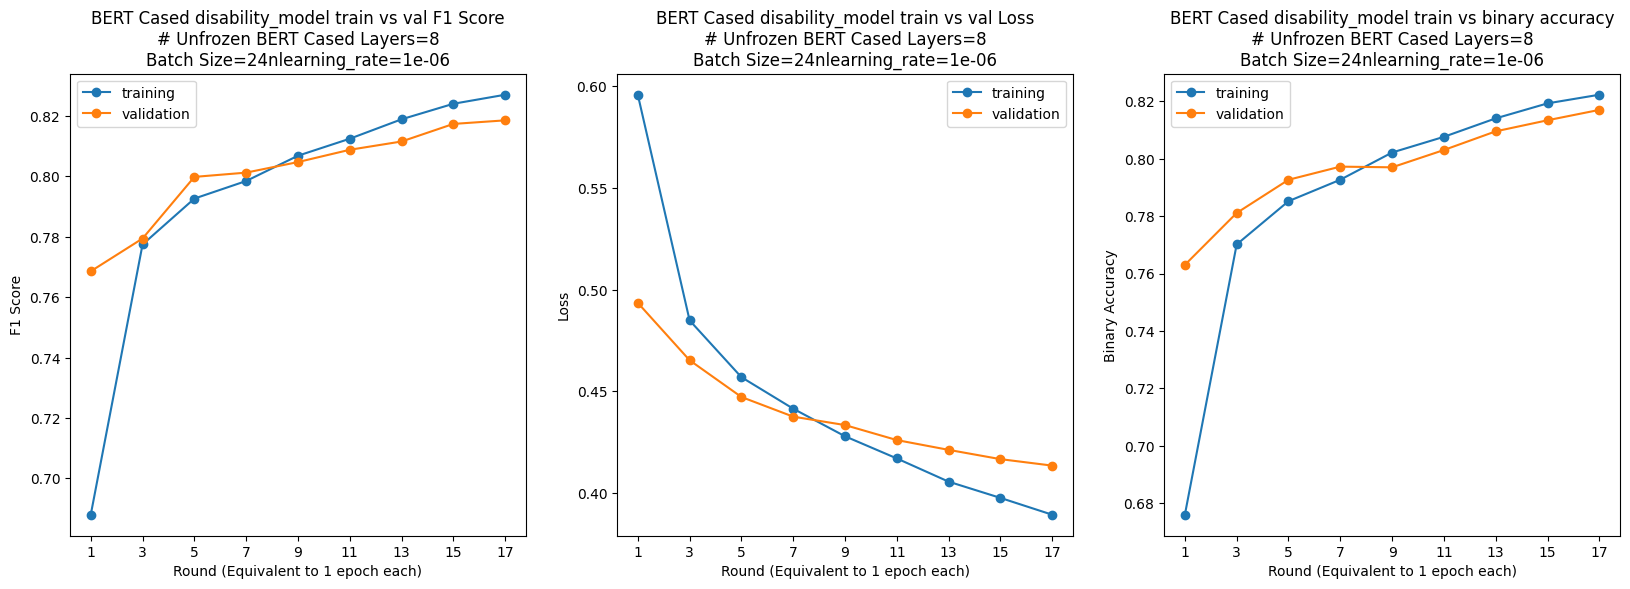

In [49]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(disability_train_f1_scores, label="training", marker='o')
axis[0].plot(disability_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[0].set_title('BERT Cased disability_model train vs val F1 Score\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(disability_train_loss, label="training", marker='o')
axis[1].plot(disability_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[1].set_title('BERT Cased disability_model train vs val Loss\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(disability_train_binary_accuracy, label="training", marker='o')
axis[2].plot(disability_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[2].set_title('BERT Cased disability_model train vs binary accuracy\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Plots for Sexual Orientation Model

In [50]:
sexual_orientation_train_f1_scores = [sexual_orientation_round2_history.history['f1_score'][0][0],
                     sexual_orientation_round4_history.history['f1_score'][0][0],
                     sexual_orientation_round6_history.history['f1_score'][0][0],
                     sexual_orientation_round8_history.history['f1_score'][0][0],
                     sexual_orientation_round10_history.history['f1_score'][0][0],
                     sexual_orientation_round12_history.history['f1_score'][0][0],
                     sexual_orientation_round14_history.history['f1_score'][0][0],
                     sexual_orientation_round16_history.history['f1_score'][0][0],
                     sexual_orientation_round18_history.history['f1_score'][0][0]]
sexual_orientation_val_f1_scores = [sexual_orientation_round2_history.history['val_f1_score'][0][0],
                     sexual_orientation_round4_history.history['val_f1_score'][0][0],
                     sexual_orientation_round6_history.history['val_f1_score'][0][0],
                     sexual_orientation_round8_history.history['val_f1_score'][0][0],
                     sexual_orientation_round10_history.history['val_f1_score'][0][0],
                     sexual_orientation_round12_history.history['val_f1_score'][0][0],
                     sexual_orientation_round14_history.history['val_f1_score'][0][0],
                     sexual_orientation_round16_history.history['val_f1_score'][0][0],
                     sexual_orientation_round18_history.history['val_f1_score'][0][0]]
sexual_orientation_train_loss = [sexual_orientation_round2_history.history['loss'][0],
                     sexual_orientation_round4_history.history['loss'][0],
                     sexual_orientation_round6_history.history['loss'][0],
                     sexual_orientation_round8_history.history['loss'][0],
                     sexual_orientation_round10_history.history['loss'][0],
                     sexual_orientation_round12_history.history['loss'][0],
                     sexual_orientation_round14_history.history['loss'][0],
                     sexual_orientation_round16_history.history['loss'][0],
                     sexual_orientation_round18_history.history['loss'][0]]
sexual_orientation_val_loss = [sexual_orientation_round2_history.history['val_loss'][0],
                     sexual_orientation_round4_history.history['val_loss'][0],
                     sexual_orientation_round6_history.history['val_loss'][0],
                     sexual_orientation_round8_history.history['val_loss'][0],
                     sexual_orientation_round10_history.history['val_loss'][0],
                     sexual_orientation_round12_history.history['val_loss'][0],
                     sexual_orientation_round14_history.history['val_loss'][0],
                     sexual_orientation_round16_history.history['val_loss'][0],
                     sexual_orientation_round18_history.history['val_loss'][0]]
sexual_orientation_train_binary_accuracy = [sexual_orientation_round2_history.history['binary_accuracy'][0],
                     sexual_orientation_round4_history.history['binary_accuracy'][0],
                     sexual_orientation_round6_history.history['binary_accuracy'][0],
                     sexual_orientation_round8_history.history['binary_accuracy'][0],
                     sexual_orientation_round10_history.history['binary_accuracy'][0],
                     sexual_orientation_round12_history.history['binary_accuracy'][0],
                     sexual_orientation_round14_history.history['binary_accuracy'][0],
                     sexual_orientation_round16_history.history['binary_accuracy'][0],
                     sexual_orientation_round18_history.history['binary_accuracy'][0]]
sexual_orientation_val_binary_accuracy = [sexual_orientation_round2_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round4_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round6_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round8_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round10_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round12_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round14_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round16_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round18_history.history['val_binary_accuracy'][0]]


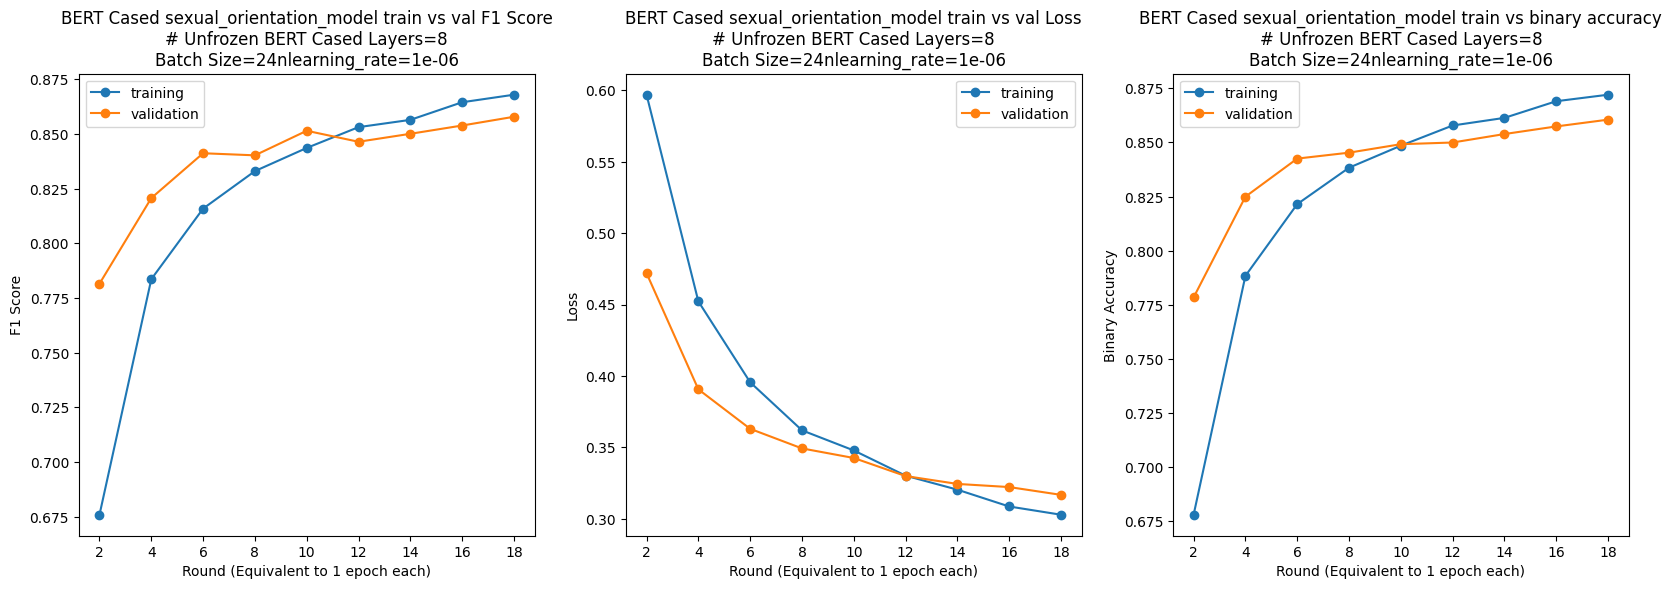

In [51]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(sexual_orientation_train_f1_scores, label="training", marker='o')
axis[0].plot(sexual_orientation_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[0].set_title('BERT Cased sexual_orientation_model train vs val F1 Score\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(sexual_orientation_train_loss, label="training", marker='o')
axis[1].plot(sexual_orientation_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[1].set_title('BERT Cased sexual_orientation_model train vs val Loss\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(sexual_orientation_train_binary_accuracy, label="training", marker='o')
axis[2].plot(sexual_orientation_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[2].set_title('BERT Cased sexual_orientation_model train vs binary accuracy\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Save Final Model Weights if Needed

In [ ]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Sexual_Orientation_Interwoven_disability.hdf5')
sexual_orientation_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERT_Cased_Disability_Sexual_Orientation_Interwoven_sexual_orientation.hdf5')

# Keep Previous Results Below/Determine Where to Stop Training

DISABILITY MODEL RESULTS

In [ ]:
print('disability_train_f1_scores:', disability_train_f1_scores)
print('disability_val_f1_scores:', disability_val_f1_scores)
print('\ndisability_train_loss:', disability_train_loss)
print('disability_val_loss:', disability_val_loss)
print('\ndisability_train_binary_accuracy:', disability_train_binary_accuracy)
print('disability_val_binary_accuracy:', disability_val_binary_accuracy)

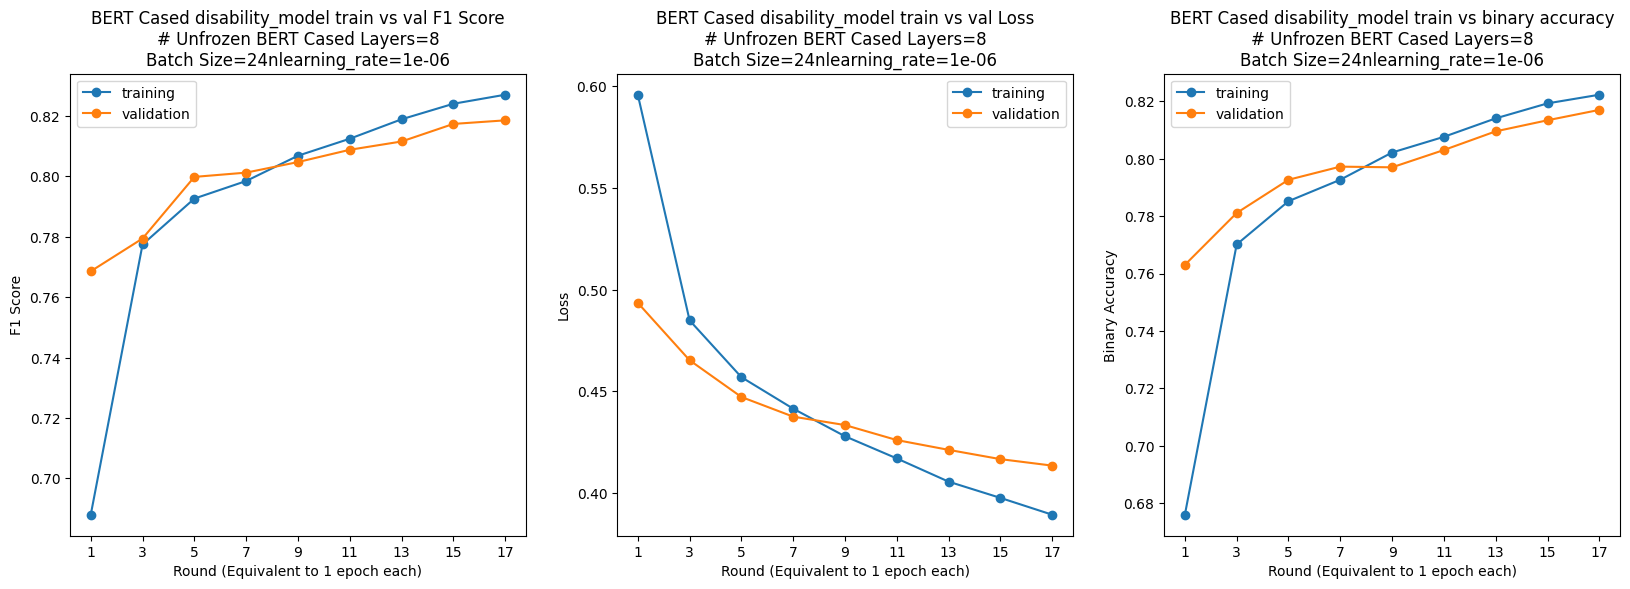

In [ ]:
# DISABILITY MODEL PLOTS - DON'T RUN THIS CELL
# From the curves below, we'll keep the disability_model weights at round 9

SEXUAL ORIENTATION MODEL RESULTS

In [ ]:
print('sexual_orientation_train_f1_scores:', sexual_orientation_train_f1_scores)
print('sexual_orientation_val_f1_scores:', sexual_orientation_val_f1_scores)
print('\nsexual_orientation_train_loss:', sexual_orientation_train_loss)
print('sexual_orientation_val_loss:', sexual_orientation_val_loss)
print('\nsexual_orientation_train_binary_accuracy:', sexual_orientation_train_binary_accuracy)
print('sexual_orientation_val_binary_accuracy:', sexual_orientation_val_binary_accuracy)

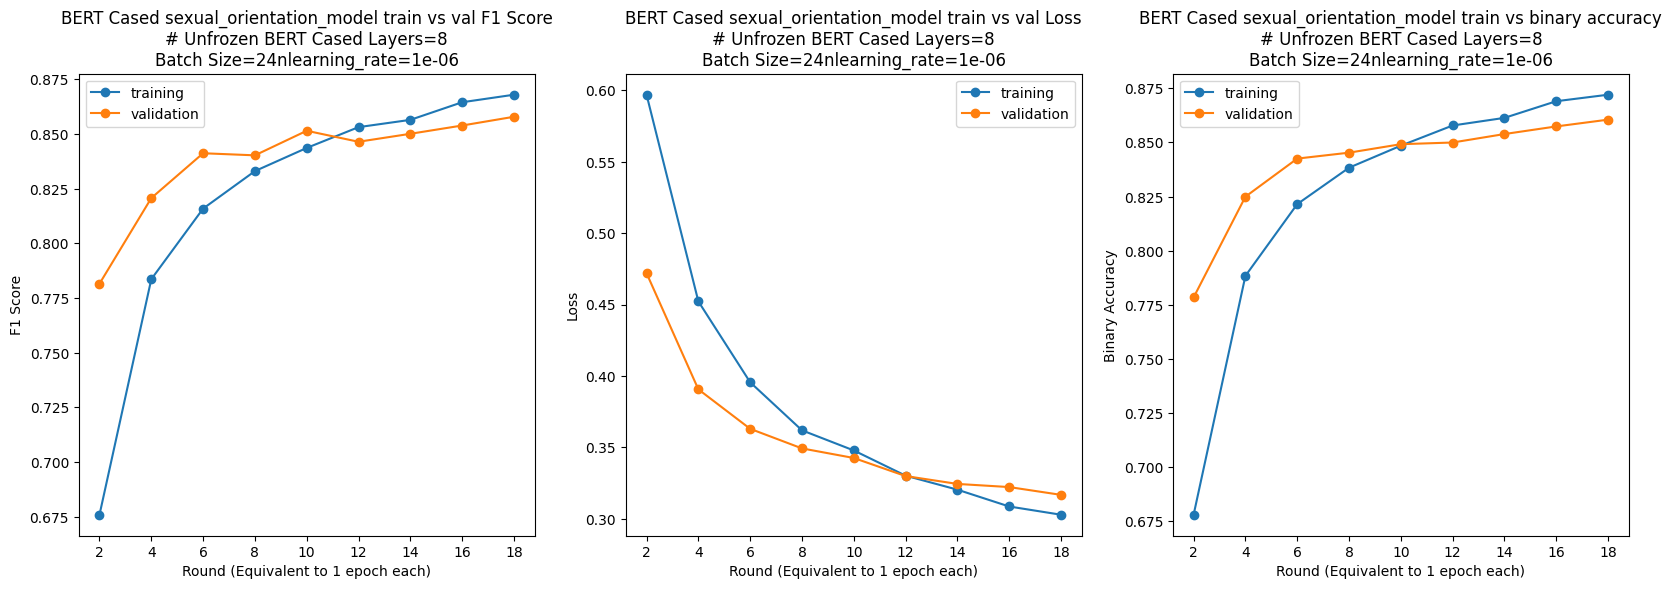

In [ ]:
# SEXUAL ORIENTATION MODEL PLOTS - DON'T RUN THIS CELL
# From the curves below, we'll keep the sexual_orientation_model weights at round  10